In [223]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [224]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [225]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [226]:
class Island:
    def __init__(self, xcentr = 5, ycentr = 5, radius = 1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius
        
    def belongs_to_boarder(self, x, y):
        if ((x - self.xcentr)**2 + (y - self.ycentr)**2 <= self.radius**2):
            return True
        else:
            return False
        
    def get_dist(self, x, y):
        return ((x - self.xcentr)**2 + (y - self.ycentr)**2) ** 0.5 - self.radius
        
    def draw_island(self):
        return plt.Circle((self.xcentr, self.ycentr), self.radius)
    
    def getCoords(self):
        return [self.xcentr, self.ycentr]

In [239]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [248]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.island.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        return [math.atan2(dyf, dxf) - self.ship.direction, math.atan2(dyf, dxf), dxi, dyi, dxf, dyf]

    def build_environment(self):
#         random.uniform(-15, 15), random.uniform(-15, 15)
        self.island = Island()
        self.flag = Island(9.5, 5, 0.5)
        self.ship = Ship(direction=math.pi)
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction = math.pi / 6
        elif action == 1:
            self.ship.direction = -math.pi / 6
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        self.ship.move(dt)
        
        self.ship.add_position()

        self.d[self.i] = self.get_state()

        next_state = self.d[self.i]

        self.i += 1
        
        if (self.flag.belongs_to_boarder(next_state[0], next_state[1])):
            reward = 1000
            done = True
            
            self.d = {}
            self.i = 0

        elif (self.island.belongs_to_boarder(next_state[0], next_state[1])):
            reward = -1000
            done = True

            self.d = {}
            self.i = 0
            
        elif len(self.ship.get_positions()) > 300:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -100

        else:
            reward = (self.prev_dist - self.flag.get_dist(next_state[0], next_state[1])) * 5
            # reward += 1 / (0.1 + self.ship.sum_d)
            done = False
        
        self.prev_dist = self.flag.get_dist(next_state[0], next_state[1])

        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.island.draw_island())
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

In [249]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 6
EPISODES = 20000

In [250]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 60)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(60, 180)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(180, 60)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(60, NUM_ACTIONS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return x

In [251]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]

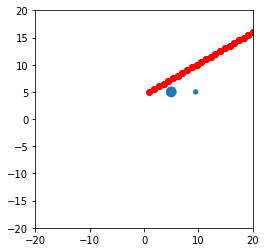

  2%|█▉                                                                          | 500/20000 [05:22<4:05:48,  1.32it/s]

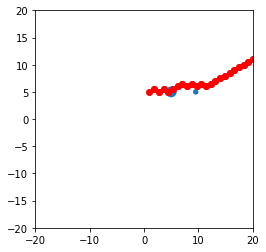

  5%|███▊                                                                       | 1000/20000 [11:33<3:57:42,  1.33it/s]

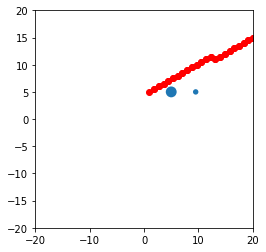

  8%|█████▋                                                                     | 1500/20000 [17:42<3:47:43,  1.35it/s]

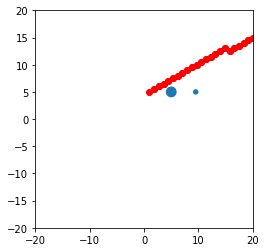

 10%|███████▌                                                                   | 2000/20000 [23:51<3:41:46,  1.35it/s]

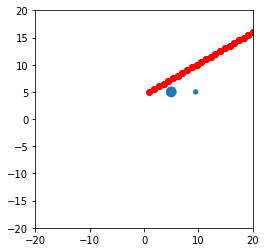

 12%|█████████▍                                                                 | 2500/20000 [30:00<3:34:46,  1.36it/s]

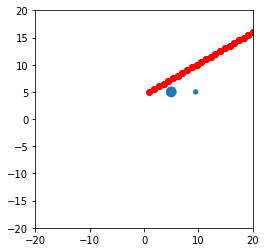

 15%|███████████▎                                                               | 3000/20000 [36:09<3:26:56,  1.37it/s]

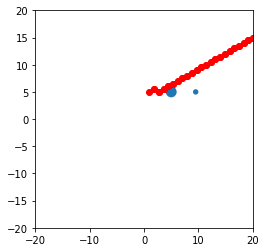

 18%|█████████████▏                                                             | 3500/20000 [42:18<3:22:18,  1.36it/s]

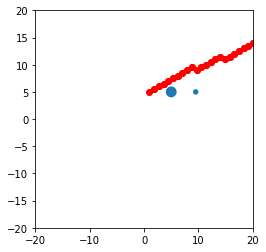

 20%|███████████████                                                            | 4000/20000 [48:28<3:16:46,  1.36it/s]

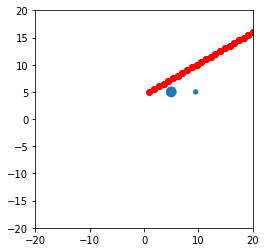

 22%|████████████████▉                                                          | 4500/20000 [54:37<3:12:07,  1.34it/s]

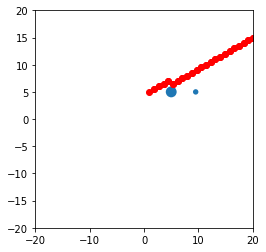

 25%|██████████████████▎                                                      | 5000/20000 [1:00:47<3:04:46,  1.35it/s]

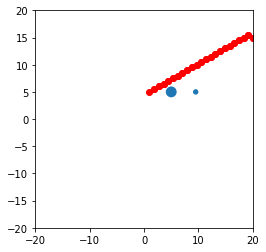

 28%|████████████████████                                                     | 5500/20000 [1:06:56<2:58:30,  1.35it/s]

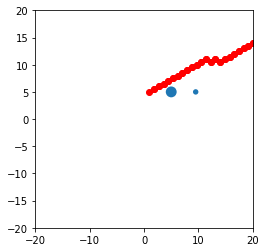

 30%|█████████████████████▉                                                   | 6000/20000 [1:13:06<2:53:21,  1.35it/s]

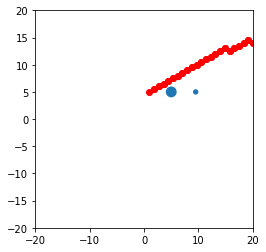

 32%|███████████████████████▋                                                 | 6500/20000 [1:19:16<2:46:41,  1.35it/s]

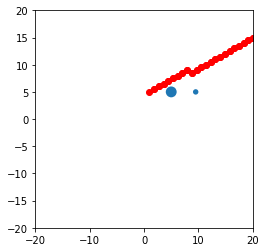

 35%|█████████████████████████▌                                               | 7000/20000 [1:25:25<2:40:05,  1.35it/s]

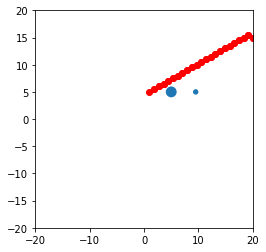

 38%|███████████████████████████▍                                             | 7500/20000 [1:31:35<2:32:49,  1.36it/s]

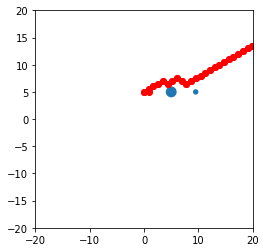

 40%|█████████████████████████████▏                                           | 8000/20000 [1:37:44<2:28:07,  1.35it/s]

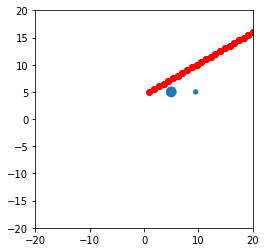

 42%|███████████████████████████████                                          | 8500/20000 [1:43:54<2:20:46,  1.36it/s]

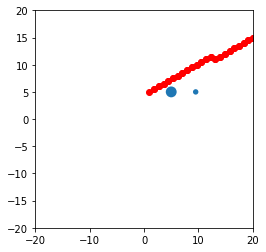

 45%|████████████████████████████████▊                                        | 9000/20000 [1:50:04<2:16:05,  1.35it/s]

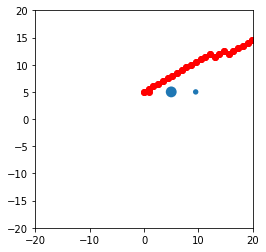

 48%|██████████████████████████████████▋                                      | 9500/20000 [1:56:14<2:09:41,  1.35it/s]

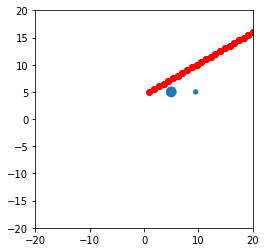

 50%|████████████████████████████████████                                    | 10000/20000 [2:02:24<2:03:08,  1.35it/s]

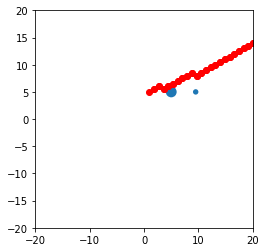

 52%|█████████████████████████████████████▊                                  | 10500/20000 [2:08:33<1:57:21,  1.35it/s]

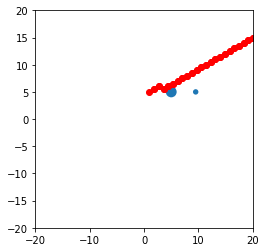

 55%|███████████████████████████████████████▌                                | 11000/20000 [2:14:43<1:50:33,  1.36it/s]

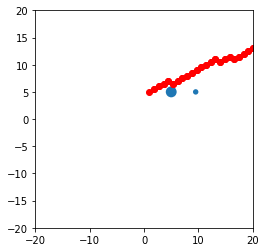

 57%|█████████████████████████████████████████▍                              | 11500/20000 [2:20:54<1:44:57,  1.35it/s]

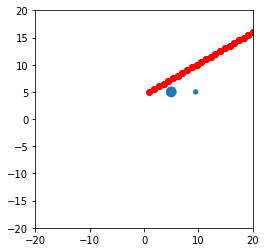

 60%|███████████████████████████████████████████▏                            | 12000/20000 [2:27:04<1:38:51,  1.35it/s]

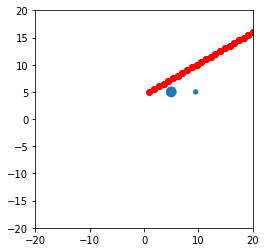

 62%|█████████████████████████████████████████████                           | 12500/20000 [2:33:14<1:32:34,  1.35it/s]

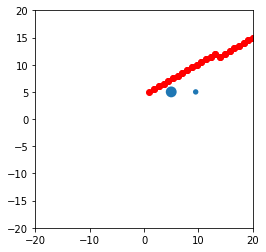

 65%|██████████████████████████████████████████████▊                         | 13000/20000 [2:39:24<1:25:43,  1.36it/s]

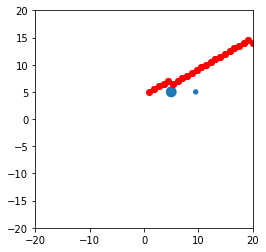

 68%|████████████████████████████████████████████████▌                       | 13500/20000 [2:45:33<1:20:13,  1.35it/s]

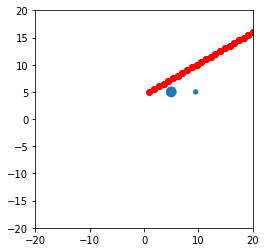

 70%|██████████████████████████████████████████████████▍                     | 14000/20000 [2:51:43<1:14:07,  1.35it/s]

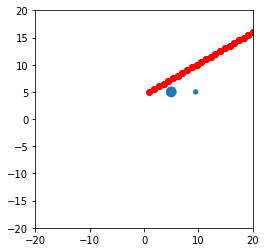

 72%|████████████████████████████████████████████████████▏                   | 14500/20000 [2:57:53<1:07:15,  1.36it/s]

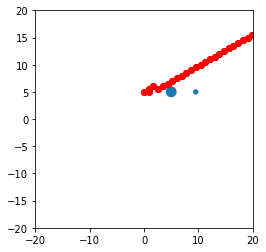

 75%|██████████████████████████████████████████████████████                  | 15000/20000 [3:04:03<1:01:21,  1.36it/s]

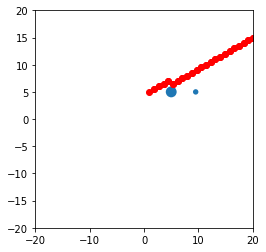

 78%|█████████████████████████████████████████████████████████▎                | 15500/20000 [3:10:13<55:33,  1.35it/s]

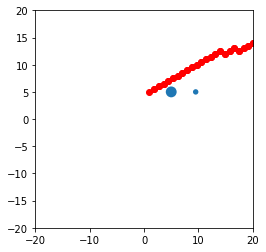

 80%|███████████████████████████████████████████████████████████▏              | 16000/20000 [3:16:23<49:29,  1.35it/s]

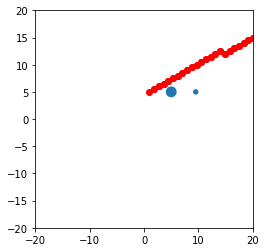

 82%|█████████████████████████████████████████████████████████████             | 16500/20000 [3:22:33<43:04,  1.35it/s]

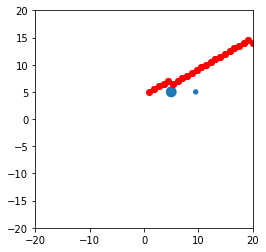

 85%|██████████████████████████████████████████████████████████████▉           | 17000/20000 [3:28:43<37:07,  1.35it/s]

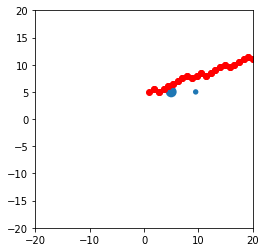

 88%|████████████████████████████████████████████████████████████████▊         | 17500/20000 [3:34:53<30:49,  1.35it/s]

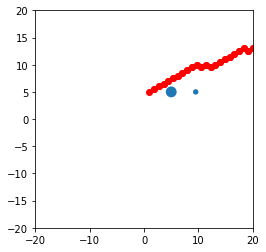

 90%|██████████████████████████████████████████████████████████████████▌       | 18000/20000 [3:41:03<24:35,  1.36it/s]

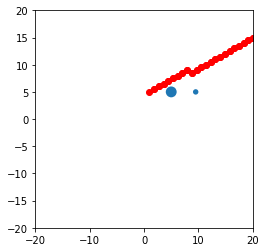

 92%|████████████████████████████████████████████████████████████████████▍     | 18500/20000 [3:47:13<18:25,  1.36it/s]

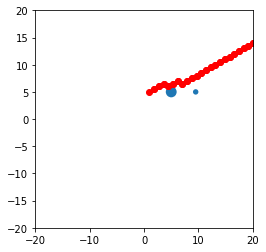

 95%|██████████████████████████████████████████████████████████████████████▎   | 19000/20000 [3:53:23<12:18,  1.35it/s]

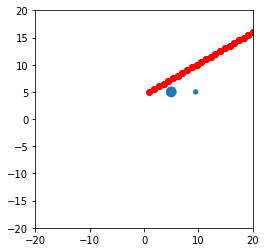

 98%|████████████████████████████████████████████████████████████████████████▏ | 19500/20000 [3:59:33<06:10,  1.35it/s]

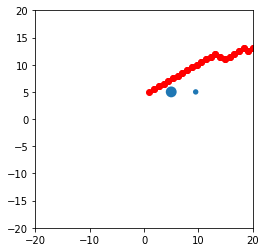

 98%|████████████████████████████████████████████████████████████████████████▍ | 19569/20000 [4:00:26<05:17,  1.36it/s]


KeyboardInterrupt: 

In [252]:
rewards = []

def main():
    net = DQN()
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                # print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 500 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )